In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
%run MakeDataset.py

Training data shape:  (126, 500, 3)
Testing data shape:  (27, 500, 3)
Validation data shape:  (27, 500, 3)


## Task 1 : Exploratory Data Analysis (EDA)

In [65]:
from MakeDataset import *

print(X_train)
print(y_train)
print(X_val.shape)

X_merged = np.concatenate((X_train, X_val), axis=0)
y_merged = np.concatenate((y_train, y_val), axis=0)

[[[ 1.025523   -0.04926786  0.05208086]
  [ 1.024647   -0.05038679  0.05060927]
  [ 1.024841   -0.05028516  0.05457738]
  ...
  [ 1.021391   -0.09425633 -0.02702328]
  [ 1.023305   -0.09057553 -0.02542393]
  [ 1.020692   -0.09100618 -0.0220361 ]]

 [[ 0.9713407  -0.3158209  -0.1999865 ]
  [ 0.9682391  -0.3150911  -0.1993361 ]
  [ 0.9651731  -0.315073   -0.2025312 ]
  ...
  [ 0.9749378  -0.2952632  -0.1954644 ]
  [ 0.9769526  -0.2960558  -0.1905169 ]
  [ 0.9746849  -0.2960369  -0.1865659 ]]

 [[ 1.017788   -0.318247    0.03187263]
  [ 1.009447   -0.3116634   0.05299603]
  [ 0.9496541  -0.3129629   0.1020035 ]
  ...
  [ 1.566298   -0.2886436  -0.05385565]
  [ 1.600778   -0.4233569  -0.05220614]
  [ 1.392855   -0.504855   -0.02617574]]

 ...

 [[ 0.9953756  -0.1514519   0.2133466 ]
  [ 0.9984037  -0.1495055   0.2166136 ]
  [ 0.998579   -0.1492797   0.2154218 ]
  ...
  [ 0.9951706  -0.153255    0.2288959 ]
  [ 0.9947926  -0.1547556   0.2272195 ]
  [ 0.9963573  -0.1547045   0.2274891 ]]

 [

Import Libraries

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tsfel
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [67]:
# 
activity_labels = {
    1: "WALKING",
    2: "WALKING UPSTAIRS",
    3: "WALKING DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

In [68]:
accx_train = X_train[:,:,0]
accy_train = X_train[:,:,1]
accz_train = X_train[:,:,2]


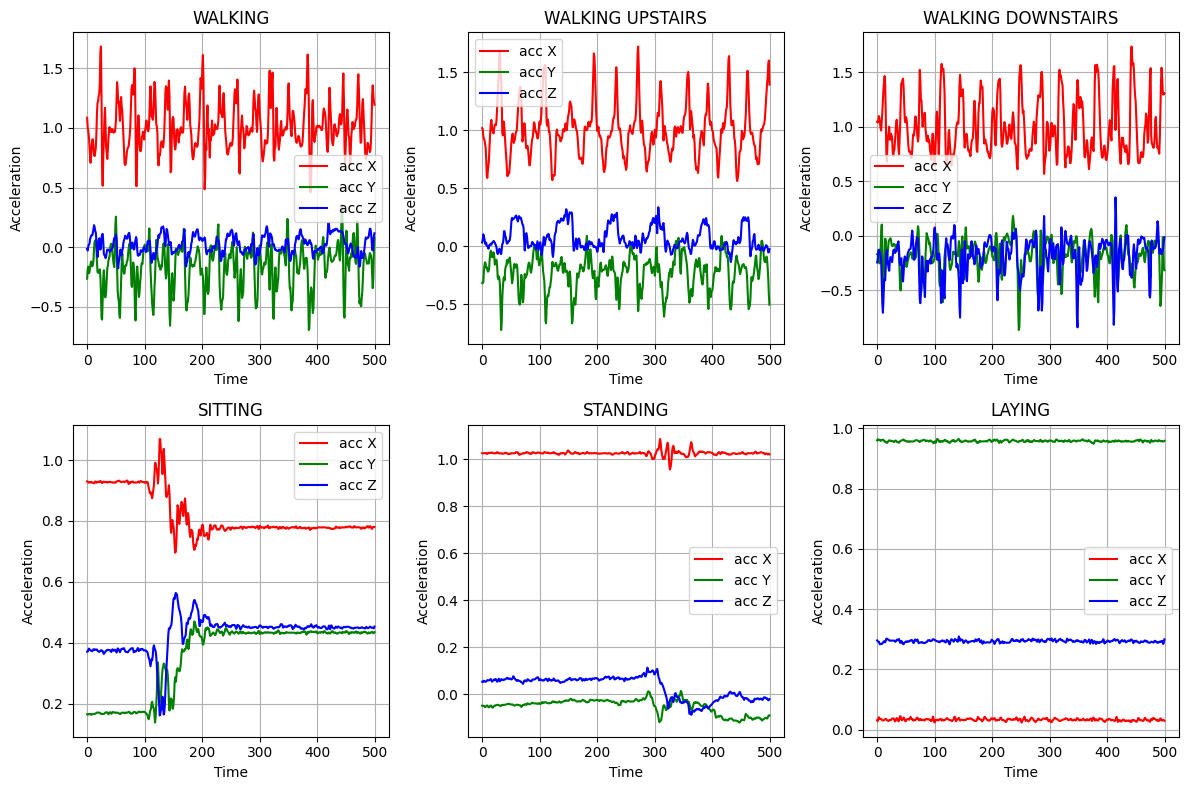

In [69]:
activity_classes = np.unique(y_train)

colors = ['red', 'green', 'blue']
labels = ['acc X', 'acc Y', 'acc Z']

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, activity in enumerate(activity_classes):
    waveform = X_train[y_train == activity][0]
    
    for j in range(3):
        axes[i].plot(waveform[:, j], color=colors[j], label=labels[j])
    
    axes[i].set_title(activity_labels[activity])
    axes[i].legend(loc='best')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Acceleration')
    axes[i].grid(True)
for j in range(len(activity_classes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Question 1: Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data?


From the above plots, we can easily differentiate between the static activities (like laying, standing, and sitting) and dynamic activities (like walking, walking upstairs, and walking downstairs). This is because in dynamic activities, the variance seen is greater. Also, among activities belonging to the same class there are alot of similarities in the trends of the time series data. The model might be able to classify the activities as per their classes but further classification may require some advanced techniques (like hyperparameters tuning, etc.).

2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2+acc_y^2+acc_z^2)$ for each activity and justify your answer.

In [70]:
# Finding the total acceleration as sum of square of acceleration in each direction
total_acc_train = np.sum(np.square(X_train), axis = -1)
total_acc_train.shape
total_acc_test = np.sum(np.square(X_test), axis = -1)
print(total_acc_test.shape)

(36, 500)


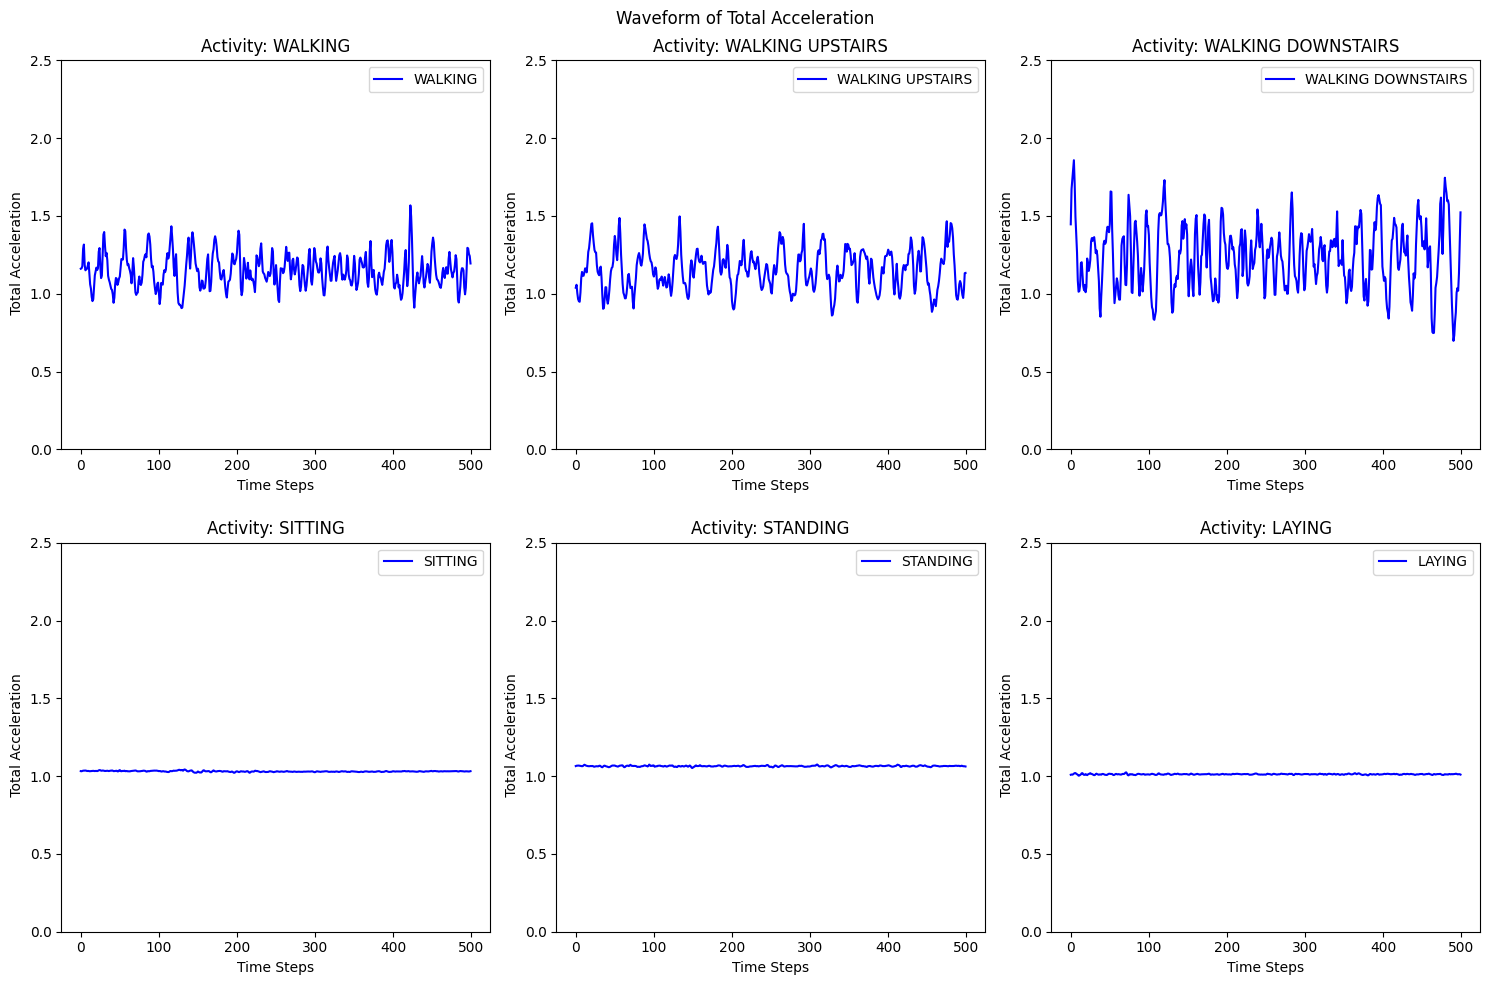

In [71]:
# Total/ Linear accelaration plot
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    class_indices = np.where(y_train == i+1)[0]
    x= X_train[class_indices][:, :, 0]
    y= X_train[class_indices][:, :, 1]
    z= X_train[class_indices][:, :, 2]
    lin_acc=x**2 + y**2 + z**2                                  #Linear Acceleration
    plt.plot(np.mean(lin_acc, axis=0), label=f'{activity_labels[i + 1]}',c='blue')
    plt.ylim(0,2.5)
    plt.title(f'Activity: {activity_labels[i + 1]}')
    plt.xlabel('Time Steps')
    plt.ylabel(' Total Acceleration')
    plt.tight_layout(h_pad=2)
    plt.suptitle("Waveform of Total Acceleration")
    # plt.savefig("Total_acc_subplot",dpi=300)
    plt.legend()
plt.show()

we can clearly see the difference between static and dynamic activities. Dynamic activities show large and frequent changes in total or linear acceleration over time, while static activities have almost constant acceleration with very little variation.

These clear differences make it easier for a model to separate static activities from dynamic ones. However, it can still be difficult for the model to tell apart activities within the same group—for example, distinguishing one dynamic activity from another, or one static activity from another—since their acceleration patterns look more similar.

Flattening the Training, Testing, and Validation data

In [72]:
X_train_flattened = X_train.reshape((-1, 1500))
X_test_flattened = X_test.reshape((-1, 1500))
X_val_flattened = X_val.reshape((-1, 1500))
X_merged_flattened = X_merged.reshape((-1, 1500))

print(X_train_flattened.shape)
print(X_test_flattened.shape)
print(X_val_flattened.shape)

(108, 1500)
(36, 1500)
(36, 1500)


### 3. Visualize the data using PCA.

PCA on total Acceleration

(144, 500)


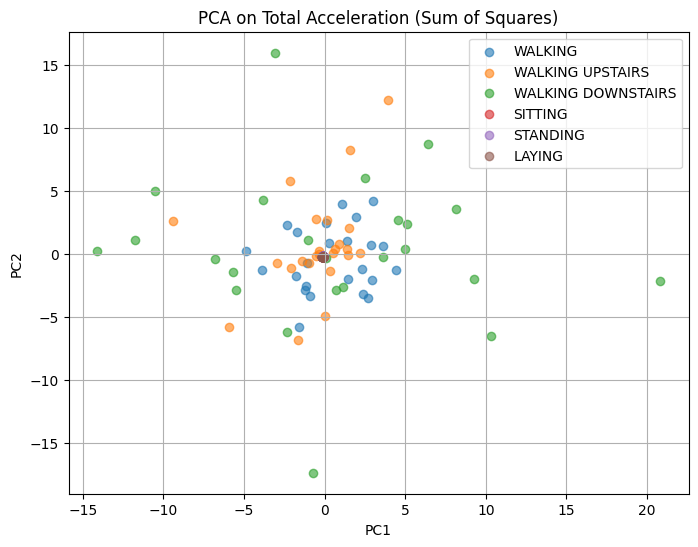

In [73]:
# PCA (reduce timesteps → 2 components)
pca = PCA(n_components=2)
X_pca_total = pca.fit_transform(total_acc_train)
accx = X_merged[:, :, 0]
accy = X_merged[:, :, 1]
accz = X_merged[:, :, 2]
total_acc = accx**2 + accy**2 + accz**2
print(total_acc.shape)
re_total_acc = total_acc.reshape((144, 500))
X_pca_total = pca.fit_transform(total_acc)


plt.figure(figsize=(8,6))
for label in np.unique(y_train):
    plt.scatter(X_pca_total[y_merged == label, 0],
                X_pca_total[y_merged == label, 1],
                label=activity_labels[label], alpha=0.6)
plt.title("PCA on Total Acceleration (Sum of Squares)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()
plt.show()


PCA on the features provided by the Dataset

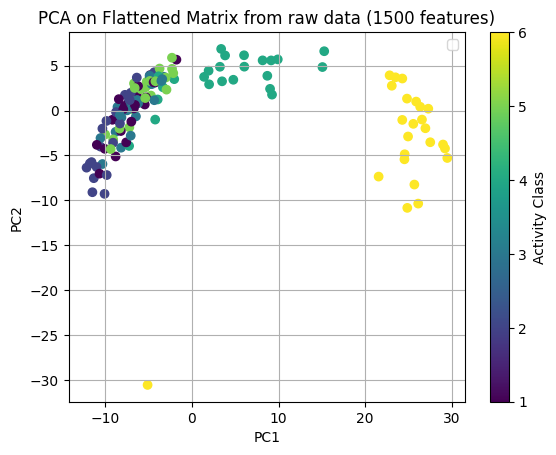

In [74]:
# PCA on 1500 features (flattened matrix)

pca = PCA(n_components = 2)
flat_data = pca.fit_transform(X_merged_flattened)

plt.scatter(flat_data[:, 0], flat_data[:, 1], c = y_merged, cmap = 'viridis')
plt.title("PCA on Flattened Matrix from raw data (1500 features)")
plt.colorbar(label='Activity Class')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

### using TSFEL (a featurizer library) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

In [75]:
cfg = tsfel.get_features_by_domain()
print(re_total_acc.shape)

# Extract features based on the raw data
X_train_extracted = tsfel.time_series_features_extractor(cfg, X_merged.reshape((-1,3)), fs=5, window_size=500)
X_test_extract = tsfel.time_series_features_extractor(cfg, X_test.reshape((-1,3)), fs=5, window_size=500)
print("Shape of extracted matrix ",X_train_extracted.shape)

(144, 500)


/Users/gauravbudhwani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gauravbudhwani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gauravbudhwani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gauravbudhwani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, current

/Users/gauravbudhwani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gauravbudhwani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gauravbudhwani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gauravbudhwani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, current

Shape of extracted matrix  (144, 468)


In [76]:
print("The features extracted are as follows")
pd.get_option('display.max_columns', 2000)
print(pd.DataFrame(X_train_extracted.columns))
print(X_train_extracted.columns[23])

The features extracted are as follows
                             0
0            0_Absolute energy
1       0_Area under the curve
2            0_Autocorrelation
3              0_Average power
4                   0_Centroid
..                         ...
463  2_Wavelet variance_0.31Hz
464  2_Wavelet variance_0.42Hz
465  2_Wavelet variance_0.62Hz
466  2_Wavelet variance_1.25Hz
467       2_Zero crossing rate

[468 rows x 1 columns]
0_Interquartile range


In [77]:
pca_tsfel=PCA(n_components=2)
data_new=pca_tsfel.fit_transform(X_train_extracted)
data_new= pd.DataFrame(data_new,columns=["PCA Feature 1", "PCA Feature 2"])

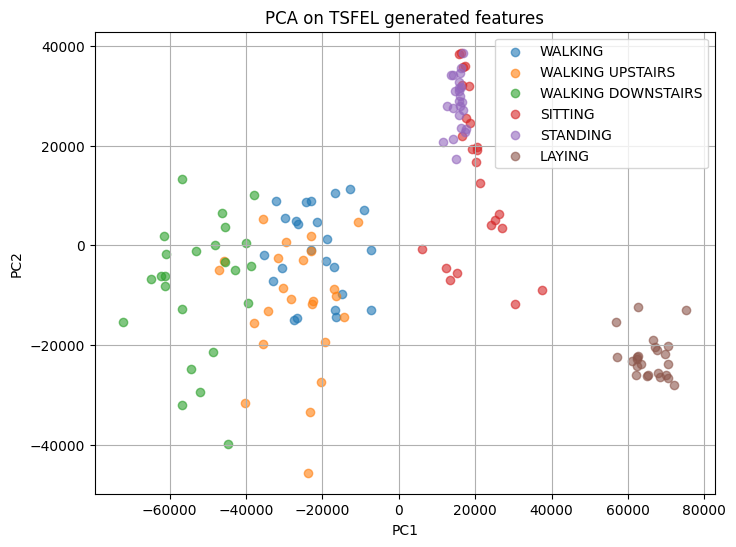

In [78]:
plt.figure(figsize=(8,6))

# Loop over unique activity classes
for label in np.unique(y_merged):
    plt.scatter(
        data_new.iloc[y_merged == label, 0], 
        data_new.iloc[y_merged == label, 1],
        label=activity_labels[label],  # activity_labels should map index → name
        alpha=0.6
    )

plt.title('PCA on TSFEL generated features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.legend()
plt.show()


The scatter plot of PCA applied on the TSFEL-generated feature matrix shows much clearer clustering of different activity classes compared to PCA on the total acceleration data, where the classes are heavily mixed together.

In the featurised data, most activity classes can be separated more easily, whereas in the case of PCA on the 1500-feature raw matrix, only two classes (class 4 and class 6) are clearly distinguishable. On the other hand, with PCA on total acceleration, it is difficult to separate even a single class.

This means that drawing decision boundaries on the total acceleration plot or the raw 1500-feature matrix plot is highly unreliable. In contrast, decision boundaries can be drawn much more effectively in the featurised data, allowing for higher classification accuracy.

The reason behind this improved separation is that the featurised dataset captures statistical patterns hidden in the raw data. For example, activities like walking upstairs, downstairs, or just walking have high variance in acceleration, while static activities such as standing, sitting, or lying down have very low variance. Similarly, the mean acceleration values can also help distinguish between different activities. TSFEL extracts such statistical features (mean, variance, etc.), which provide richer information for classification.

On the other hand, total acceleration is not a good feature for activity recognition because it collapses the important differences in the X, Y, and Z directions into a single value, losing valuable information.

Similarly, relying only on the raw 1500-feature matrix (instantaneous acceleration values) can be misleading, since there may be moments where walking and sitting show the same acceleration value. If classification is based only on these instantaneous values, it can lead to incorrect decisions. Considering statistical measures (like mean and variance over time windows) avoids this problem and provides a more reliable basis for distinguishing activities.

In [79]:
# Traning Decision Tree over TSFEL featurized matrix
decisionTree=DecisionTreeClassifier(max_depth=4)
decisionTree.fit(X_train_extracted,y_merged)
#plot_tree(decisionTree,filled=True)
#plt.savefig("Decision Tree featured matrix")

DecisionTreeClassifier(max_depth=4)

In [80]:
# Predicting output for X_test to calculate accuracy
y_pred= decisionTree.predict(X_test_extract)
accuracy= decisionTree.score(X_test_extract,y_test)
print(accuracy)

0.8333333333333334


confusion matrix of the features obtained by TSFEL and provided in the dataset. 

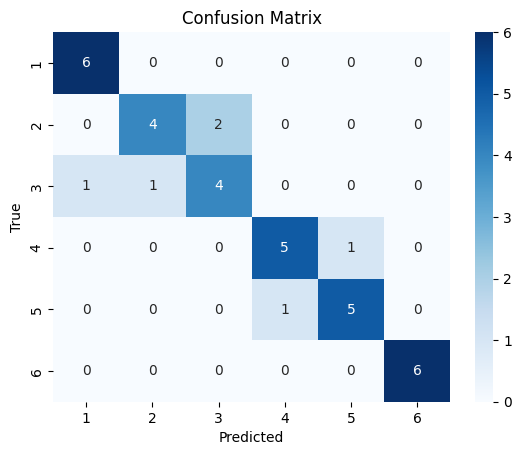

In [81]:
# Ploting confusion matrix to visualise the prediction done by the model
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
cm_featured=cm

[0.5, 0.7222222222222222, 0.8055555555555556, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334]


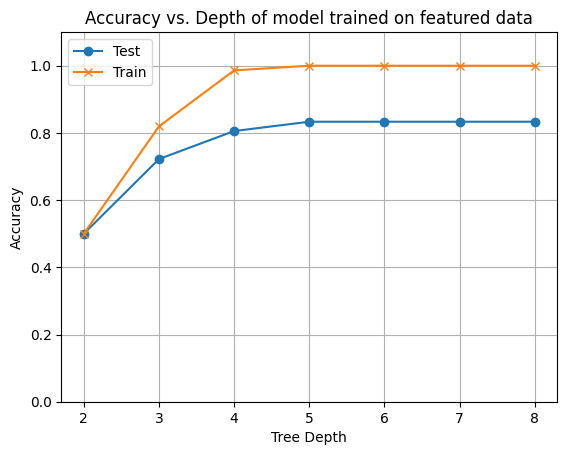

In [82]:
# Varying depths from 2 to 9
depths = list(range(2, 9))

# Lists to store accuracies and confusion matrices
accuracies_test = []
accuracies_train = []
conf_matrices = []

# Train Decision Trees with varying depths
for depth in depths:
    dt_classifier = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_classifier.fit(X_train_extracted, y_merged)
    
    # Accuracy on the test set
    y_pred_test = dt_classifier.predict(X_test_extract)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies_test.append(accuracy)
    
    #Accuracy on train set
    y_pred_train = dt_classifier.predict(X_train_extracted)
    accuracy = accuracy_score(y_merged,y_pred_train)
    accuracies_train.append(accuracy)

print(accuracies_test)

plt.plot(depths, accuracies_test, marker='o',label="Test")
plt.plot(depths, accuracies_train, marker='x',label="Train")
plt.title('Accuracy vs. Depth of model trained on featured data')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.grid(True)
plt.legend()
plt.show()

In [83]:
# TSFEL using variancethreshold for building the correlation matrix
cfg = tsfel.get_features_by_domain()

# X_train shape is (n_samples, timesteps, n_channels)
X_features_list = []

for sample in X_train:  # loop through samples
    # Convert to DataFrame for TSFEL (columns = x,y,z)
    df = pd.DataFrame(sample, columns=['acc_x', 'acc_y', 'acc_z'])
    
    # Extract features for this sample
    feats = tsfel.time_series_features_extractor(cfg, df, verbose=0)
    X_features_list.append(feats.values[0])

X_features = np.array(X_features_list)   # shape = (n_samples, n_features)
X_tsfel = np.vstack(X_features_list)



In [84]:
cfg = tsfel.get_features_by_domain()
X_tsfel = []
feature_names = []
for i in range(total_acc.shape[0]):
    X_tsf = tsfel.time_series_features_extractor(cfg, pd.DataFrame(total_acc[i]), fs=50)
    X_tsfel.append(X_tsf.values)
    if feature_names == []:
        feature_names = X_tsf.columns.tolist()
X_tsfel = np.vstack(X_tsfel)
X_tsfel_df = pd.DataFrame(X_tsfel, columns=feature_names)
corr_features = tsfel.correlated_features(X_tsfel_df)
X_tsfel_df.drop(corr_features, axis=1, inplace=True)

X_tsfel_test = []
X_test_total_acc = np.sum(X_test**2, axis = 2)
for i in range(X_test_total_acc.shape[0]):
    X_tsf = tsfel.time_series_features_extractor(cfg, pd.DataFrame(X_test_total_acc[i]), fs=50)
    X_tsfel_test.append(X_tsf.values)
X_tsfel_test = np.vstack(X_tsfel_test)

In [85]:
selector = VarianceThreshold()
X_tsfel_df_var = selector.fit_transform(X_tsfel_df)
kbest_selector = SelectKBest(score_func=f_classif, k=10)
X_tsfel_df_k = kbest_selector.fit_transform(X_tsfel_df_var, y_merged)
scaler = StandardScaler()
TX_train = scaler.fit_transform(X_tsfel_df_k)
#print(TX_train.shape)

Dataset Features

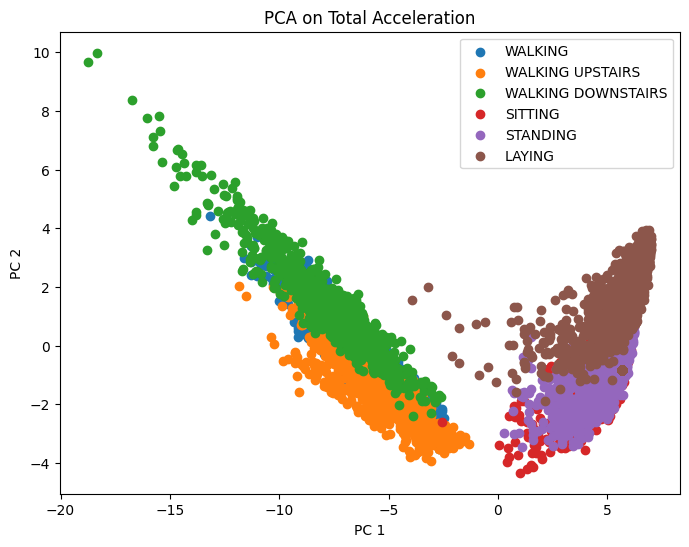

In [86]:
X_df = pd.read_csv('UCI HAR Dataset/train/X_train.txt', header=None, sep='\s+')
X_df_heads = pd.read_csv('UCI HAR Dataset/features.txt', header=None, sep='\s+')
X_df.columns = X_df_heads[1].values
y_df = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, sep='\s+')
data_with_labels = np.column_stack((X_df, y_df))

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(data_with_labels)

plt.figure(figsize=(8, 6))
for activity in np.unique(y_df):
    indices = np.where(y_df == activity)
    plt.scatter(X_train_pca[indices, 0], X_train_pca[indices, 1], label=activity_labels[activity])
plt.title('PCA on Total Acceleration')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()

Comparing the Results obtained from PCA on total acceleration, TSFEL and the dataset features, we can see that the results obtained from TSFEL are the most distinguishable. The results obtained from the dataset features are also distinguishable but not as much as TSFEL. The results obtained from the total acceleration are not distinguishable at all. This is because the total acceleration is a sum of squares of the individual accelerations and does not capture the individual variations in the accelerations. Therefore, TSFEL is the best method.

4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features?

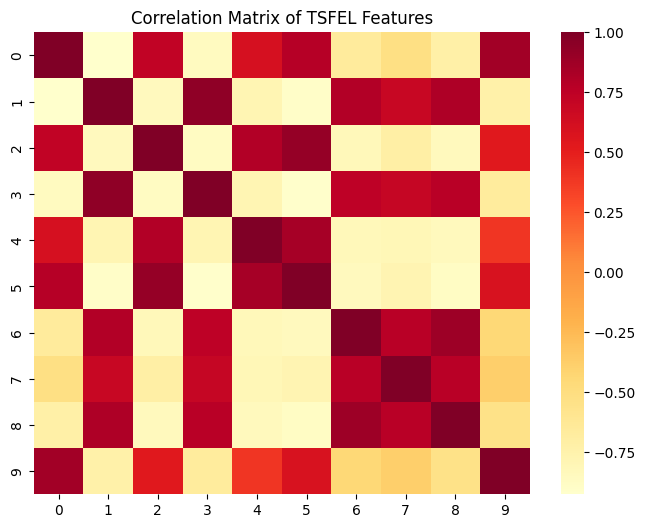

In [87]:
TX_train = pd.DataFrame(TX_train)
corr_matrix = TX_train.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='YlOrRd', annot=False)
plt.title('Correlation Matrix of TSFEL Features')
plt.show()

Most Significant features are 4.
Pairwise features (2, 3), (4, 5), (6, 7) are quite correlated to each other.
Features 8 and 9 are highly correlated to each other which may bring us to conclude that they are redundant.

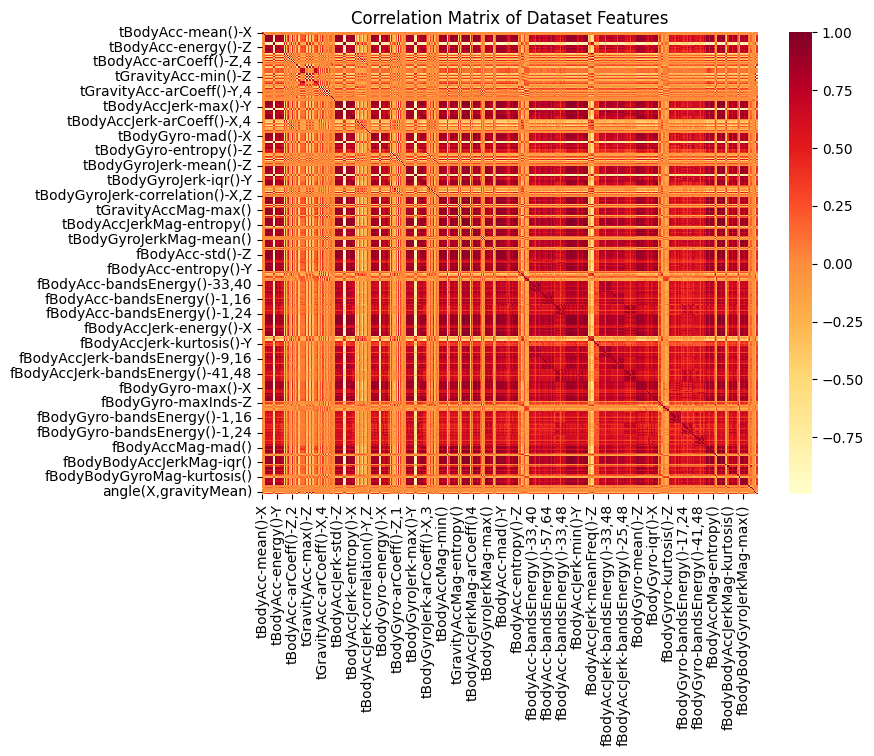

In [88]:
X_df = pd.DataFrame(X_df)
corr_matrix = X_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='YlOrRd', annot=False)
plt.title('Correlation Matrix of Dataset Features')
plt.show()

The dataset shows only a few strongly correlated features. Some pairs are highly related and may be redundant, but most features remain fairly independent. This suggests that most features can contribute useful and distinct information to the model’s learning.

## Task 2: Decision Trees for Human Activity Recognition

Reextracting the dataset features (train and test)

In [89]:
X_df_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', header=None, sep='\s+')
X_df_heads_train = pd.read_csv('UCI HAR Dataset/features.txt', header=None, sep='\s+')
X_df_train.columns = X_df_heads_train[1].values
X_df_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', header=None, sep='\s+')
X_df_heads_test = pd.read_csv('UCI HAR Dataset/features.txt', header=None, sep='\s+')
X_df_test.columns = X_df_heads_test[1].values
y_df_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, sep='\s+')
y_df_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None, sep='\s+')
#X_df = pd.concat([X_df_train, X_df_test])
#y_df = pd.concat([y_df_train, y_df_test])

Using Sklearn Library to train Decision Trees
1. Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.

Accuracy: 0.528
Precision: 0.527
Recall: 0.528
Confusion Matrix:


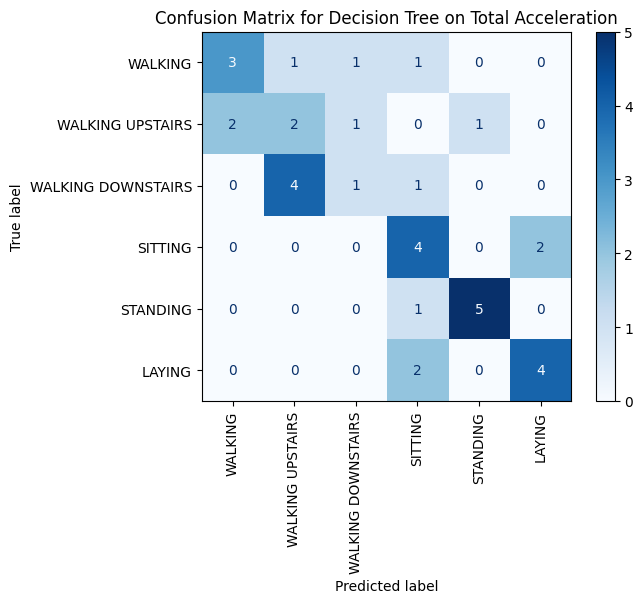

In [90]:
X_train_total_accn = total_acc_train
X_test_total_accn = total_acc_test

model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train_total_accn, y_train)
y_pred = model.predict(X_test_total_accn)
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print('Confusion Matrix:')

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_labels.values())
display.plot(cmap='Blues', xticks_rotation='vertical')
plt.xticks(rotation=90)
plt.title('Confusion Matrix for Decision Tree on Total Acceleration')
plt.show()

2. Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.

Accuracy: 0.722
Precision: 0.726
Recall: 0.722
Confusion Matrix:


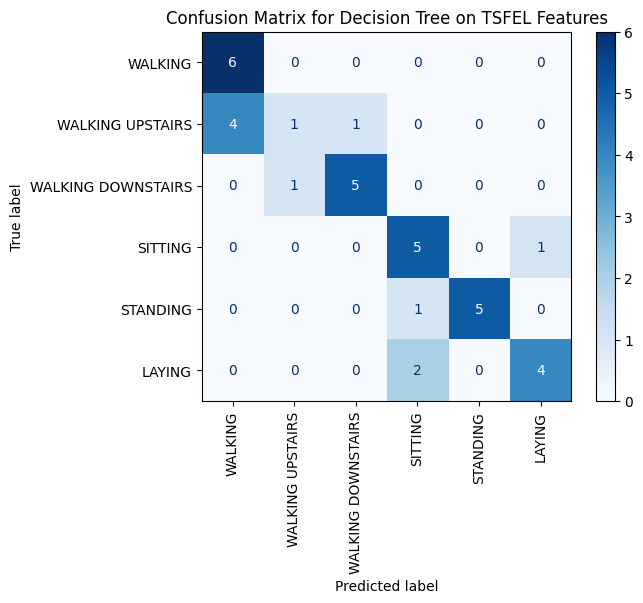

In [91]:
tsfel_model = DecisionTreeClassifier(random_state = 42)
tsfel_model.fit(X_tsfel, y_merged)
y_pred = tsfel_model.predict(X_tsfel_test)
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print('Confusion Matrix:')

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_labels.values())
display.plot(cmap='Blues', xticks_rotation='vertical')
plt.xticks(rotation=90)
plt.title('Confusion Matrix for Decision Tree on TSFEL Features')
plt.show()



3. Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.

Accuracy: 0.863
Precision: 0.864
Recall: 0.863
Confusion Matrix:


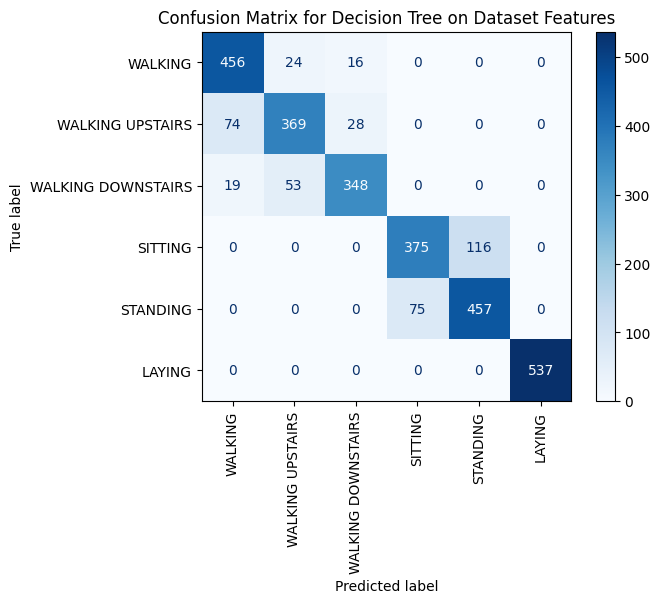

In [92]:
df_model = DecisionTreeClassifier(random_state = 42)
df_model.fit(X_df_train, y_df_train)
y_pred = df_model.predict(X_df_test)
accuracy  = accuracy_score(y_df_test, y_pred)
precision = precision_score(y_df_test, y_pred, average='weighted')
recall = recall_score(y_df_test, y_pred, average='weighted')
cm = confusion_matrix(y_df_test, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print('Confusion Matrix:')

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=activity_labels.values())
display.plot(cmap='Blues', xticks_rotation='vertical')
plt.xticks(rotation=90)
plt.title('Confusion Matrix for Decision Tree on Dataset Features')
plt.show()

4. Compare the results of the three models. Which model do you think is better?

The model performed best on the dataset features, this can be seen by the accuracy, precision, recall and confusion matrix of the model. However, it is important to note that the dataset considered while training the model actually trained on the dataset features was significantly higher which naturally gives it more learning than the rest of the datasets. Moreover, Using TSFEL on this much data is not optimal but still if only looking at the scatter plots, we can sat that TSFEL does give better results, thus it may give better results on a bigger dataset.

2. Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree.

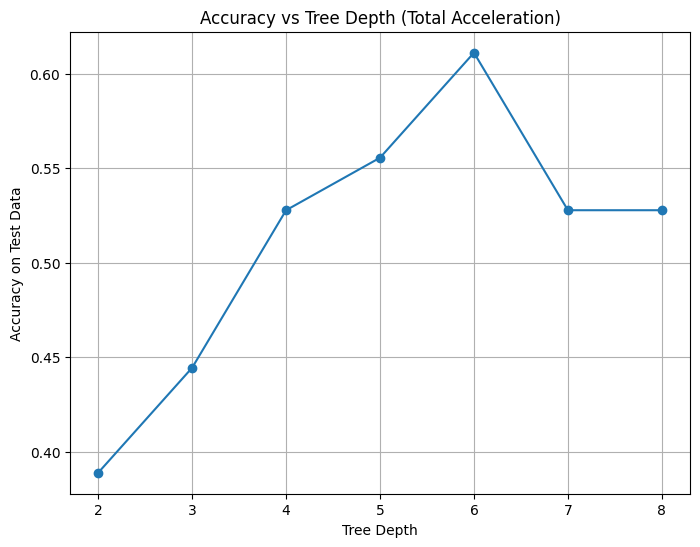

In [93]:
tree_depths = range(2, 9)
model_acc = []

for depth in tree_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(total_acc_train, y_train)
    y_pred = model.predict(total_acc_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_acc.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(tree_depths, model_acc, marker='o')
plt.title('Accuracy vs Tree Depth (Total Acceleration)')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy on Test Data')
plt.grid(True)
plt.show()

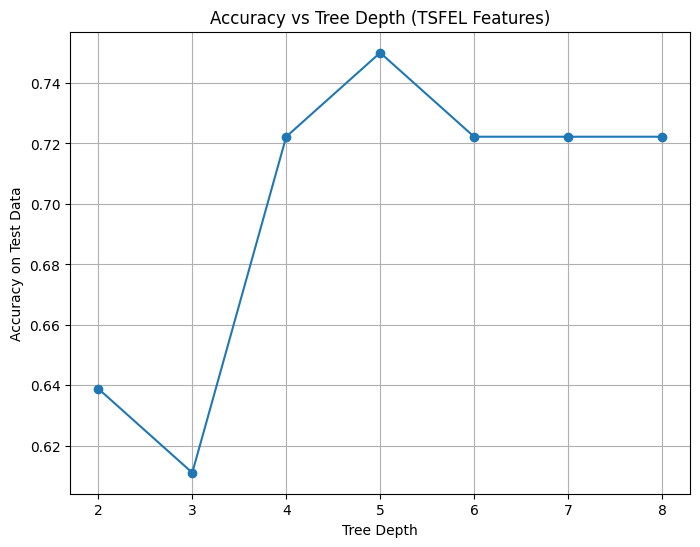

In [94]:
tree_depths = range(2, 9)
model_acc = []

for depth in tree_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_tsfel, y_merged)
    y_pred = model.predict(X_tsfel_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_acc.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(tree_depths, model_acc, marker='o')
plt.title('Accuracy vs Tree Depth (TSFEL Features)')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy on Test Data')
plt.grid(True)
plt.show()

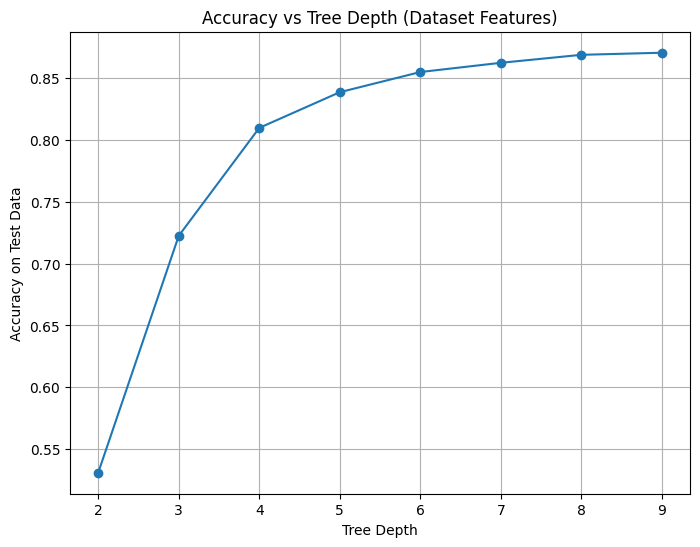

In [95]:
tree_depths = range(2, 10)
model_acc = []

for depths in tree_depths:
    model = DecisionTreeClassifier(max_depth=depths, random_state=42)
    model.fit(X_df_train, y_df_train)
    y_pred = model.predict(X_df_test)
    accuracy = accuracy_score(y_df_test, y_pred)
    model_acc.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(tree_depths, model_acc, marker='o')
plt.title('Accuracy vs Tree Depth (Dataset Features)')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy on Test Data')
plt.grid(True)
plt.show()

3. Are there any participants/ activitivies where the Model performace is bad? If Yes, Why?


The model shows poor performance in distinguishing between walking, walking downstairs, and walking upstairs. This difficulty arises because these activities generate highly similar motion patterns, which is also evident from the scatter plots.

Another contributing factor is the relatively small size of the training dataset, which limits the model’s ability to capture subtle differences between these classes. This is supported by the fact that the model trained on the provided dataset features achieved much higher accuracy—likely because the dataset was significantly larger, allowing for better learning despite the scatter plots suggesting otherwise.

Interestingly, the smaller size of the raw accelerometer dataset may also explain the absence of overfitting in that case, as the noise remains too irregular to dominate the learning process. In contrast, when training on the larger dataset features, signs of overfitting become apparent, indicating that it influences model optimization.

In [ ]:

with open('total_acc_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Task 3: Data Collection in the Wild

loading the collected data from the Physics Toolbox Suite app.

In [99]:
files = [
    "Collected Data/walking_1", "Collected Data/walking_2", "Collected Data/walking_3",
    "Collected Data/sitting_1", "Collected Data/sitting_2", "Collected Data/sitting_3",
    "Collected Data/standing_1","Collected Data/standing_2","Collected Data/standing_3",
    "Collected Data/laying_1",  "Collected Data/laying_2",  "Collected Data/laying_3",
    "Collected Data/upstairs_1","Collected Data/upstairs_2","Collected Data/upstairs_3",
    "Collected Data/downstairs_1","Collected Data/downstairs_2","Collected Data/downstairs_3",
]

In [105]:
import pandas as pd
import os

files = [r'./Collected Data/walking_1.csv', r'./Collected Data/walking_2.csv', 
         r'./Collected Data/walking_3.csv', r'./Collected Data/sitting_1.csv', 
         r'./Collected Data/sitting_2.csv', r'./Collected Data/sitting_3.csv', 
         r'./Collected Data/standing_1.csv', r'./Collected Data/standing_2.csv', 
         r'./Collected Data/standing_3.csv', r'./Collected Data/laying_1.csv', 
         r'./Collected Data/laying_2.csv', r'./Collected Data/laying_3.csv', 
         r'./Collected Data/upstairs_1.csv', r'./Collected Data/upstairs_2.csv', 
         r'./Collected Data/upstairs_3.csv', r'./Collected Data/downstairs_1.csv', 
         r'./Collected Data/downstairs_2.csv', r'./Collected Data/downstairs_3.csv']

output_folder = "./Trimmed Data"
os.makedirs(output_folder, exist_ok=True)

for file in files:
    df = pd.read_csv(file)
    total_time = df['time'].iloc[-1] - df['time'].iloc[0]
    start_time = df['time'].iloc[0] + (total_time - 10) / 2
    end_time = start_time + 10
    
    df_trimmed = df[(df['time'] >= start_time) & (df['time'] <= end_time)].reset_index(drop=True)
    
    # Keep only accx, accy, accz (your columns are ax, ay, az)
    df_trimmed = df_trimmed[['ax', 'ay', 'az']]
    df_trimmed.columns = ['accx', 'accy', 'accz']  # rename for clarity
    
    # Save
    out_file = os.path.join(output_folder, os.path.basename(file))
    df_trimmed.to_csv(out_file, index=False)
    
    print(f"{file} → trimmed to {len(df_trimmed)} samples and saved without time/atotal")


./Collected Data/walking_1.csv → trimmed to 1001 samples and saved without time/atotal
./Collected Data/walking_2.csv → trimmed to 1002 samples and saved without time/atotal
./Collected Data/walking_3.csv → trimmed to 1001 samples and saved without time/atotal
./Collected Data/sitting_1.csv → trimmed to 1002 samples and saved without time/atotal
./Collected Data/sitting_2.csv → trimmed to 1001 samples and saved without time/atotal
./Collected Data/sitting_3.csv → trimmed to 1001 samples and saved without time/atotal
./Collected Data/standing_1.csv → trimmed to 1002 samples and saved without time/atotal
./Collected Data/standing_2.csv → trimmed to 1002 samples and saved without time/atotal
./Collected Data/standing_3.csv → trimmed to 1001 samples and saved without time/atotal
./Collected Data/laying_1.csv → trimmed to 1001 samples and saved without time/atotal
./Collected Data/laying_2.csv → trimmed to 1002 samples and saved without time/atotal
./Collected Data/laying_3.csv → trimmed to

In [128]:
trimmed_folder = "./Trimmed Data"

all_data = []
target_len = 500   # desired number of rows per file
target_cols = 3     # accx, accy, accz

for file in sorted(os.listdir(trimmed_folder)):
    if file.endswith(".csv"):
        path = os.path.join(trimmed_folder, file)
        df = pd.read_csv(path)

        # Ensure only 3 columns are taken
        df = df.iloc[:, :target_cols]

        # If more rows → truncate
        if len(df) > target_len:
            df = df.iloc[:target_len, :]

        # If fewer rows → pad with zeros
        elif len(df) < target_len:
            pad_rows = target_len - len(df)
            df = pd.concat([df, pd.DataFrame(np.zeros((pad_rows, target_cols)), columns=df.columns)], 
                           ignore_index=True)

        all_data.append(df.values)

# Convert to numpy array → shape (18, 1000, 3)
collected_X_test = np.stack(all_data, axis=0)
print(collected_X_test[12])
collected_y_test = np.array([3, 3, 3, 6, 6, 6, 4, 4, 4, 5, 5, 5, 2, 2, 2, 1, 1, 1])
print(collected_X_test.shape)
print(collected_y_test.shape)

[[-0.87  0.01 -0.17]
 [-0.83  0.03 -0.18]
 [-0.8   0.   -0.18]
 ...
 [ 0.93  0.03  0.33]
 [ 1.05  0.05  0.35]
 [ 1.12  0.05  0.37]]
(18, 500, 3)
(18,)


In [129]:
X_comp = np.concatenate((X_train, X_val, X_test), axis=0)
y_comp = np.concatenate((y_train, y_val, y_test), axis=0)

X_comp_fl = X_comp.reshape((-1, 1500))
collected_X_test_f = collected_X_test.reshape((-1, 1500))

X_comp_acc = np.square(X_comp[:, :, 0]) + np.square(X_comp[:, :, 1]) + np.square(X_comp[:, :, 2])
collected_X_test_acc = np.square(collected_X_test[:, :, 0]) + np.square(collected_X_test[:, :, 1]) + np.square(collected_X_test[:, :, 2])


In [130]:
depths = list(range(2, 9))

acc_test = []
acc_train = []
conf_matrices = []

# train dt with varying depths
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_comp, y_comp)
    y_pred = model.predict(X_comp)
    accuracy = accuracy_score(y_comp, y_pred)
    acc_test.append(accuracy)
    y_pred_train = model.predict(X_comp_acc)
    accuracy_train = accuracy_score(y_comp, y_pred_train)
    acc_train.append(accuracy_train)

    y_pred_test = model.predict(collected_X_test_f)
    acc  = accuracy_score(collected_y_test, y_pred_test)
    acc_test.append(acc)
    conf_matrix = confusion_matrix(collected_y_test, y_pred_test)
    conf_matrices.append(conf_matrix)

print(acc_test)
plt.figure(figsize=(8, 6))
plt.plot(depths, acc_test, marker='o', label='Test Accuracy')
plt.plot(depths, acc_train, marker='*', label='Train Accuracy')
plt.title('Accuracy vs Tree Depth (Total Acceleration)')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for i, conf_matrix in enumerate(conf_matrices):
    plt.subplot(3, 3, i+1)
    display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=activity_labels.values())
    display.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix (Depth {depths[i]})')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


ValueError: Found array with dim 3. DecisionTreeClassifier expected <= 2.